# Modelling

Here I forecast the number of pickups happenning in a block throughout the three months given its socioeconomic factors. After analysing the dataset I concluded that it makes sense to use **Multiple Linear Regression** with OLS after applying a **log transformation** to all the variables.

We are restricted to only use the socioeconomic factors, but we would surely lower the RSME prediction error by adding more features from the original taxi dataset

## Loading the data

In [1]:
import pandas as pd, numpy as np
import geopandas as gpd

In [123]:
# Polygons of blocks in New York.
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

#socioeconomic data
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)

#number of pickups per block
pickup_counts = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col = 0)

First we build a pivot table from the acs data.

In [124]:
block_acs = acs.pivot(index = "geoid", columns = "acs_demog_var" ).droplevel(level = 0, axis = 1)
pct_nan = block_acs.isna().sum()/6339*100 #percentage of nan

Listed below are the features which have missing values (see percentage).

We will drop ```aggregate_travel_time_to_work``` and ```owner_occupied_housing_units_median_value``` since they have  94% and 28%. But regarding the rest of the features with missing values we will try to input data from surrounding blocks

In [5]:
pct_nan[pct_nan > 0]

acs_demog_var
aggregate_travel_time_to_work                                  94.289320
income_per_capita                                               1.151601
median_age                                                      1.056949
median_income                                                   7.335542
median_rent                                                     8.834201
median_year_structure_built                                     1.577536
owner_occupied_housing_units_median_value                      28.127465
renter_occupied_housing_units_paying_cash_median_gross_rent     8.392491
dtype: float64

## Inputting missing data from neighbor blocks
We could input each feature's median or the average value on Nans, but we can do better if we just take the values of the neighbor blocks, which will **more likely be similar** to the current missing one. To find each blocks´s neighbors we just slightly scale up all the block polygons and find which ones intersect.

In [6]:
nymap_scaled = nymap.copy()
nymap_scaled["geometry"] = nymap_scaled["geometry"].scale(xfact = 1.2,yfact = 1.2, origin = "center")


In [163]:
#took a while to compute this. Does not scale.
neigbors_df  = pd.DataFrame(index = nymap_scaled["geoid"], columns = nymap_scaled["geoid"])
from itertools import combinations
for x,y in combinations(nymap_scaled.values, 2):
    x_geoid, x_polygon = x
    y_geoid, y_polygon = y
    is_neighbor = x_polygon.intersects(y_polygon)
    neigbors_df.loc[x_geoid][y_geoid] = is_neighbor
    neigbors_df.loc[y_geoid][x_geoid] = is_neighbor

# We fill the Nan in the diagonal with False (intersection of block with itself) to avoid problems
neigbors_df.fillna(False, inplace = True) 

In [7]:
#neigbors_df.to_csv("neighbor_blocks_1.2.csv")
neigbors_df = pd.read_csv("./neighbor_blocks_1.2.csv", index_col=0)

In [122]:
def input_from_neighbors(df, columns_to_input, neighbor_matrix):
    data = df.copy()
    for column_name in columns_to_input:
        #We find which rows are misisng values 
        rows_missing_values = data[data[column_name].isna()].index
        for geoid in rows_missing_values:
            neighbors = neighbor_matrix[str(geoid)] #we search for neighbors of geoid
            mean_value_neighbors = data[column_name][neighbors].median() #we compute here the median of neighbors
            data.loc[geoid][column_name] = mean_value_neighbors
    return data


In [129]:
columns_to_input = ["income_per_capita","median_age", "median_income","median_rent", "median_year_structure_built", "renter_occupied_housing_units_paying_cash_median_gross_rent"]
while(block_acs.isna().sum().sum() > 0):
    block_acs = input_from_neighbors(block_acs, columns_to_input , neigbors_df)

# Drops features and checks that no longer are there missing values
block_acs.drop(["aggregate_travel_time_to_work", "owner_occupied_housing_units_median_value"], axis = 1, inplace = True)

## Transforming variables

Since we are using Linear regression, we need to check that there exist a linear dependency between features variables and the target. We might have to transform them to get to this linear relationship. 

We define below a function which performs different transformations to the data.

In [191]:
from sklearn.preprocessing import StandardScaler
from  sklearn.model_selection import train_test_split 
from scipy import stats

def data_transformation(input_data, remove_outliers = True, log_transform = ["target"]):
       
    model_data = input_data.copy()
    # Transforming columns with log
    for col in log_transform:
        model_data[col] =  np.log10(1 + model_data[col])

    # Scaling the data
    scl = StandardScaler()
    model_data_std = scl.fit_transform(model_data)
    model_data_std = pd.DataFrame(model_data_std, columns= model_data.columns, index = model_data.index)

    #Removing outliers
    if remove_outliers:
        model_data_std = model_data_std[(np.abs(stats.zscore(model_data)) < 3).all(axis = 1)]

    X = model_data_std.drop(["target"], axis = 1)
    y = model_data_std["target"]
    
    return X, y, scl

We import our data with the number of pickups per block and join it with the block_acs with inputted values.

In [132]:
pickups_per_day_per_block = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col=0)
pickup_counts = pickups_per_day_per_block["total"]

model_data = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "inner" )

model_data.rename(columns = {"total" : "target",
                             "renter_occupied_housing_units_paying_cash_median_gross_rent" : "renter_cash_payers"
                            }, inplace = True)


We plot the correlation matrix and check which variables are most correlated with our target

target                  1.000000
income_per_capita       0.402803
vacant_housing_units    0.354228
median_rent             0.350792
renter_cash_payers      0.332373
nonfamily_households    0.308532
Name: target, dtype: float64


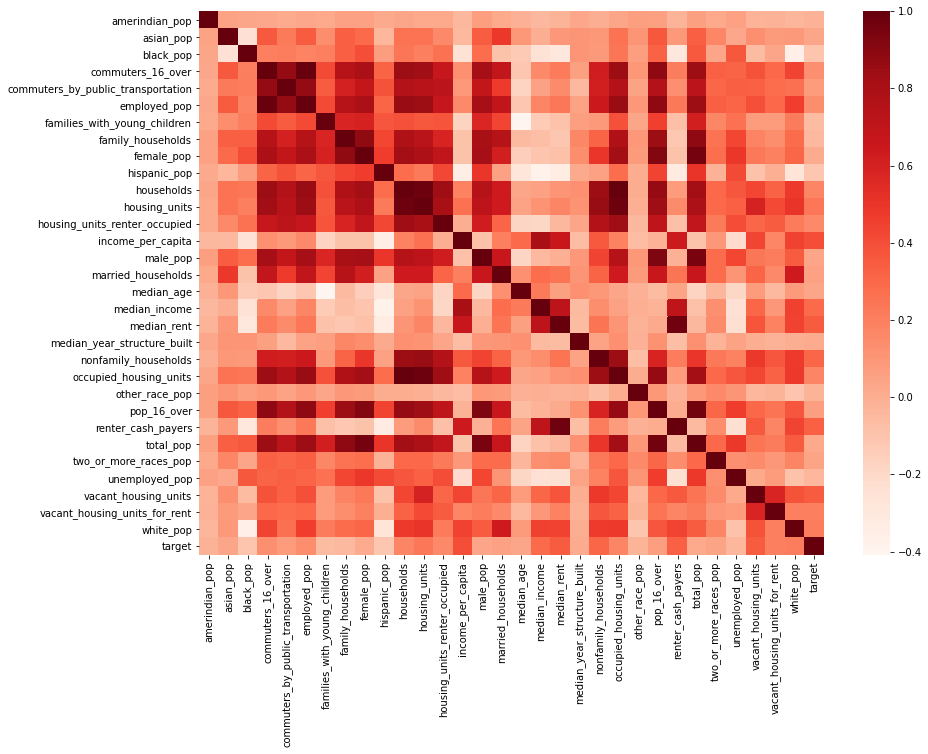

In [152]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,10))
cor = model_data.corr()

corr_target = np.abs(cor["target"]).sort_values(ascending = False)
print(corr_target.head(6))

sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

We check if there is a linear dependency after removing outliers and standarizing, **without transforming any values** 

In [158]:
def pairplot_top_n(data, corr_matrix, n):
    top_n = corr_matrix.index[:n]
    sns.pairplot(
        data,
        y_vars=["target"],
        x_vars = top_n,
        kind = "reg",
        plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
    )

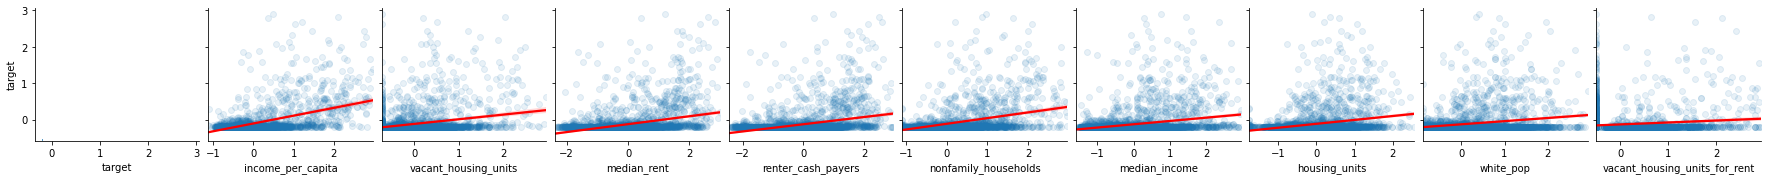

In [195]:
X_std, y_std , _ = data_transformation(model_data , remove_outliers=True, log_transform= [])
model_data_std = pd.merge(X_std, y_std, right_index=True, left_index=True)
pairplot_top_n(model_data_std, corr_target, 10)

We see that the relationship among the most correlated variables lacks linearity.

Lets try applying a **log transformation** to all the columns

In [194]:
#log_transform_cols = ["target", "income_per_capita", "nonfamily_households", "vacant_housing_units"]
log_transform_cols = model_data.columns.values # all of them
X, y , scl = data_transformation(model_data, remove_outliers=True, log_transform= log_transform_cols)
model_data_transformed = pd.merge(X,y, right_index=True, left_index=True)

target                  1.000000
income_per_capita       0.591325
nonfamily_households    0.573280
median_rent             0.428145
housing_units           0.420781
Name: target, dtype: float64


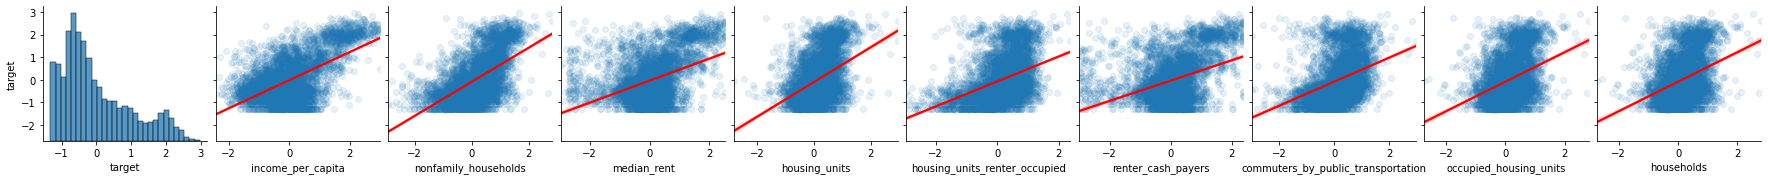

In [167]:
cor = model_data_transformed.corr()
corr_target_transformed = np.abs(cor["target"]).sort_values(ascending = False)
print(corr_target_transformed.head())
pairplot_top_n(model_data_transformed, corr_target_transformed, 10)

If we take a look at the features which are most highly correlated with our target we appreciate some linearity in the scatterplots. 

## Fitting the model

We dont need to do feature selection since Ordinary Least Squares wont overfit when using bad predictor, it will just give them less importance. The variance explained (R^2) will never decrease while adding new predictors.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 33)

In [188]:
import statsmodels.api as sm
model = linear_model.OLS(y,X)
ols_res = model.fit()
print(ols_res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.676
Model:                            OLS   Adj. R-squared (uncentered):              0.674
Method:                 Least Squares   F-statistic:                              352.1
Date:                Sat, 10 Oct 2020   Prob (F-statistic):                        0.00
Time:                        14:10:17   Log-Likelihood:                         -4279.9
No. Observations:                5093   AIC:                                      8620.
Df Residuals:                    5063   BIC:                                      8816.
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

## Checking if the model complies with the linear regression assumptions


### Normality
We check if the residuals are normally distributed by drawing a qqplot. We see that that most of the residuals behave normally (excepting those for high values)

In the other hand, the Jarque Bera test is giving us a very high value, which means that the residuals might not be normal.

[('Jarque-Bera', 138.04601117729723),
 ('Chi^2 two-tail prob.', 1.0560623226174423e-30),
 ('Skew', 0.3630270071196537),
 ('Kurtosis', 3.6341826070917906)]

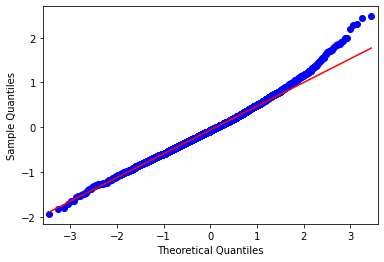

In [169]:
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.gofplots import qqplot

predictions = ols_res.predict(X_train)
residuals = y_train - predictions

qqplot(residuals, line = 'q')
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = jarque_bera(residuals)
list(zip(name,test))

### Homoscedasticity
The residuals should have constant variance across the feature space. We can see that it is not the case since the shape of the scatterplot is moreless conic.

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

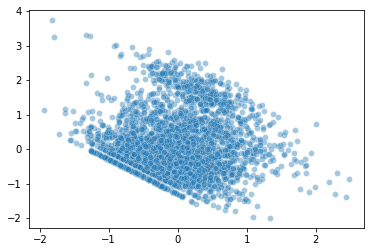

In [170]:
sns.scatterplot(residuals, predictions, alpha = 0.4)


### Multicollinearity and autocorrelation
The condition number of the coefficient matrix is a good measure of multicollinearity. In our case it has a very high value, which indicates that multicollinearity is unfortunately present

The Durbin-Watson test is 1.2, which indicates the presence of positive autocorrelation

In [171]:
np.linalg.cond(ols_res.model.exog)

1.1136664811146098e+16

## Interpretation of the results and conclusions

After testing with several algorithms (RandomForest, GaussianRegressor) I chose a linear regression model, since it was giving the best R^2 metric and had the lowest RSME of the models.

We have an $R^2$ value of 0.68, which explains a fair amount of variability in the dataset. However we have realised that our data complies does not follow very well he assumptions of linear regression, which might result on bad predictions.

To solve these problems we could try to apply some more linear transformations to some of the features.
Of course, using more features from the taxi dataset would surely have a positive impact.

After taking a look at the predictions in the map, I notice that the error is very high at some points, for example at the airports, which have very low predicted values since the socioeconomic data of the people living in those areas cant say anything about the millions of passengers arriving by plane to their blocks. 

Variables about the city urbanism at each block would surely complement very well with the socioeconomic factors about people. For example:
* Whether there is an airport or not in a block.
* Number of office buildings in a block.
* Number of cinemas in a block.
* Number of restaurants in a block.
* Number of schools in a block. (probably inversely correlated)
* Block area.
* Etc


It is worth to point out that we should **not be using the number of dropoffs** in a block as a variable. It is a variable which is surely highly correlated with the number of pickups, but it gives us information which a priori we do not have. Therefore we should not be using in a model. It would be like trying to predict the number of births in a country using the number of pregnant women.

## Output the model estimations

In [206]:
def reverse_transformation(X, scl, pred = None):
    standard_matrix = pd.DataFrame(X)
    if pred is not None:
        standard_matrix["target"] = pred
    original_matrix = scl.inverse_transform(standard_matrix) # we destandarized the data
    #log_pickups = original_matrix[:,-1] # We select the last column
    original_pickups = np.power(10, original_matrix)  - 1 # We invert the log transformation
    rounded_pickups = np.round(original_pickups, decimals = 0).astype(np.int64)
    return pd.DataFrame(rounded_pickups, index = X.index, columns= X.columns)

In [196]:
X_pred, y_pred, scl_pred = data_transformation(model_data, remove_outliers=False, log_transform = log_transform_cols)
pred = ols_res.predict(X_pred)

In [207]:
predicted_pickups = reverse_transformation(X_pred, scl_pred, pred = pred)
#original_pickups = reverse_transformation(X_pred, scl_pred)

In [211]:
pred_pickups_df = predicted_pickups.rename(columns = {"target": "pred_pickups"})["pred_pickups"]

In [214]:
pred_pickups_df.to_csv("./files/pred_pickups.csv")